# End-to-End Salary Prediction Pipeline
This notebook builds a complete pipeline including preprocessing, feature encoding, model training, evaluation, and optional hyperparameter tuning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
sns.set(style='whitegrid')
df = pd.read_csv('ai_job_dataset.csv')

In [2]:
# Feature selection
df['posting_date'] = pd.to_datetime(df['posting_date'])
df['application_deadline'] = pd.to_datetime(df['application_deadline'])
df['job_duration'] = (df['application_deadline'] - df['posting_date']).dt.days
features = ['experience_level', 'employment_type', 'company_size', 'remote_ratio',
            'job_description_length', 'benefits_score', 'job_duration']
X = df[features]
y = df['salary_usd']

In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Categorical and numerical columns
cat_cols = ['experience_level', 'employment_type', 'company_size']
num_cols = ['remote_ratio', 'job_description_length', 'benefits_score', 'job_duration']

In [5]:
# Pipeline setup
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['remote_ratio',
                                                   'job_description_length',
                                                   'benefits_score',
                                                   'job_duration']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['experience_level',
                                                   'employment_type',
                                                   'company_size'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [6]:
# Evaluation
y_pred = pipeline.predict(X_test)
print(f'R2 Score: {r2_score(y_test, y_pred):.2f}')
print(f'MSE: {mean_squared_error(y_test, y_pred):,.2f}')

R2 Score: 0.60
MSE: 1,459,441,488.21


In [8]:
param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [None, 10, 20]
}
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)
grid.fit(X_train, y_train)
print(f'Best Params: {grid.best_params_}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'model__max_depth': 10, 'model__n_estimators': 150}


In [9]:
# Select a random sample of 10 rows from the test set
sample_indices = np.random.choice(X_test.index, size=10, replace=False)
X_sample = X_test.loc[sample_indices]
y_actual = y_test.loc[sample_indices]
y_predicted = pipeline.predict(X_sample)

# Combine into a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Actual Salary (USD)': y_actual,
    'Predicted Salary (USD)': y_predicted.astype(int)
})
comparison_df


,Actual Salary (USD),Predicted Salary (USD)
11009,179159,140154
5980,142508,124527
11994,113063,101262
5674,150813,222452
2122,70859,107489
13627,147056,182275
8029,104697,98612
2075,131774,144489
7044,131033,122344
14084,116790,70861


## Plot Actual vs Predicted Values

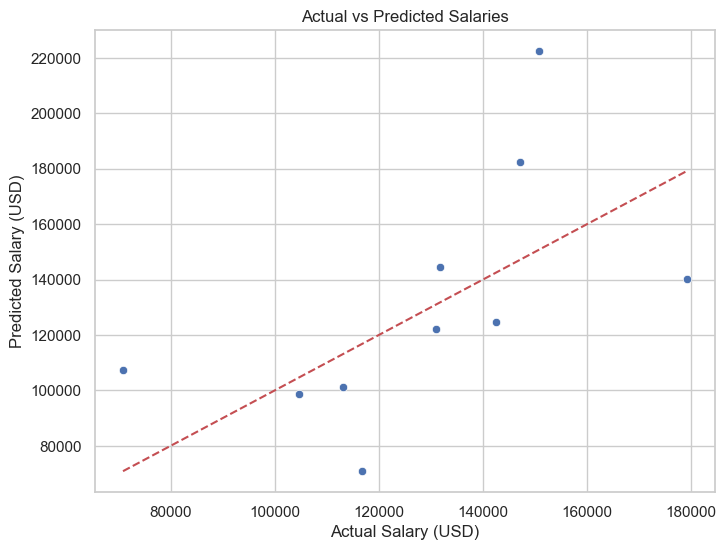

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_actual, y=y_predicted)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')  # 45-degree line
plt.title('Actual vs Predicted Salaries')
plt.xlabel('Actual Salary (USD)')
plt.ylabel('Predicted Salary (USD)')
plt.grid(True)
plt.show()
